# Incidence de la varicelle

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

In [3]:
data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

In [4]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202246          7   3041     1390    4692       5           3   
1     202245          7   3827     1720    5934       6           3   
2     202244          7   4271     2231    6311       6           3   
3     202243          7   5863     3302    8424       9           5   
4     202242          7   3770     1950    5590       6           3   
5     202241          7   4177     2219    6135       6           3   
6     202240          7   4883     1472    8294       7           2   
7     202239          7   2041      331    3751       3           0   
8     202238          7   1771      419    3123       3           1   
9     202237          7   1725      499    2951       3           1   
10    202236          7   1069      178    1960       2           1   
11    202235          7   1581      400    2762       2           0   
12    202234          7   2266      788    3744       3           1   
13    202233          7   7340        0   17399      11           0   
14    202232          7   7801     4086   11516      12           6   
15    202231          7   6896     4170    9622      10           6   
16    202230          7   9039     5770   12308      14           9   
17    202229          7  14851    10060   19642      22          15   
18    202228          7  15471    11028   19914      23          16   
19    202227          7  21191    16198   26184      32          24   
20    202226          7  16854    12806   20902      25          19   
21    202225          7  22246    18011   26481      34          28   
22    202224          7  22458    18105   26811      34          27   
23    202223          7  18772    14875   22669      28          22   
24    202222          7  18916    14941   22891      29          23   
25    202221          7  20310    16307   24313      31          25   
26    202220          7  23585    19004   28166      36          29   
27    202219          7  18593    14181   23005      28          21   
28    202218          7  17851    13963   21739      27          21   
29    202217          7  20314    16001   24627      31          24   
...      ...        ...    ...      ...     ...     ...         ...   
1638  199126          7  17608    11304   23912      31          20   
1639  199125          7  16169    10700   21638      28          18   
1640  199124          7  16171    10071   22271      28          17   
1641  199123          7  11947     7671   16223      21          13   
1642  199122          7  15452     9953   20951      27          17   
1643  199121          7  14903     8975   20831      26          16   
1644  199120          7  19053    12742   25364      34          23   
1645  199119          7  16739    11246   22232      29          19   
1646  199118          7  21385    13882   28888      38          25   
1647  199117          7  13462     8877   18047      24          16   
1648  199116          7  14857    10068   19646      26          18   
1649  199115          7  13975     9781   18169      25          18   
1650  199114          7  12265     7684   16846      22          14   
1651  199113          7   9567     6041   13093      17          11   
1652  199112          7  10864     7331   14397      19          13   
1653  199111          7  15574    11184   19964      27          19   
1654  199110          7  16643    11372   21914      29          20   
1655  199109          7  13741     8780   18702      24          15   
1656  199108          7  13289     8813   17765      23          15   
1657  199107          7  12337     8077   16597      22          15   
1658  199106          7  10877     7013   14741      19          12   
1659  199105          7  10442     6544   14340      18          11   
1660  199104          7   7913     4563   11263      14           8   
1661  199103          7  15387    10484   20290      27          18   
1662  199102          7  16277  

In [5]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

On remarque qu'il n'y a pas de données manquantes. 

In [8]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

In [9]:
sorted_data = raw_data.set_index('period').sort_index()

In [10]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

On vérifie bien qu'il ne manque pas de données dans le jeu de données, et on fait une prepière représentation des données. 

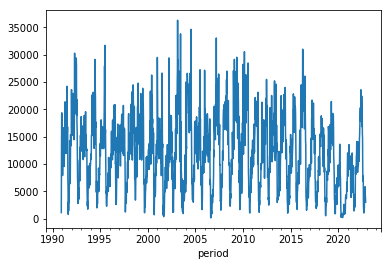

In [11]:
sorted_data['inc'].plot()

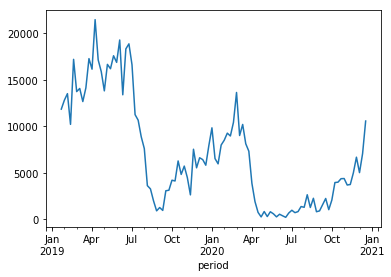

In [14]:
sorted_data['inc'][-200:-100].plot()

## Etude de l'incidence

On remarque que le creux de l'épidémie semble se situer en septembre, on va donc choisir le 
1er septembre comme date de début de l'année. 

Notre tâche est un peu compliquée par le fait que l'année ne comporte
pas un nombre entier de semaines. Nous modifions donc un peu nos périodes
de référence: à la place du 1er septembre de chaque année, nous utilisons le
premier jour de la semaine qui contient le 1er septembre.

Comme l'incidence de syndrome grippal est très faible en septembre, cette
modification ne risque pas de fausser nos conclusions.

Encore un petit détail: les données commencent en semaine 49 de 1990, ce qui
rend la première année incomplète. Nous commençons donc l'analyse en 1991.

In [21]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

In [22]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    #assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

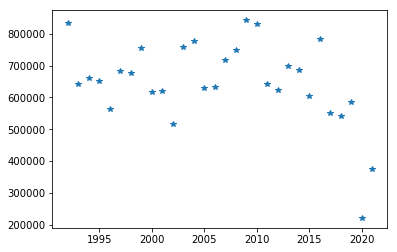

In [23]:
yearly_incidence.plot(style='*')

In [24]:
yearly_incidence.sort_values()

2020    221186
2021    376290
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

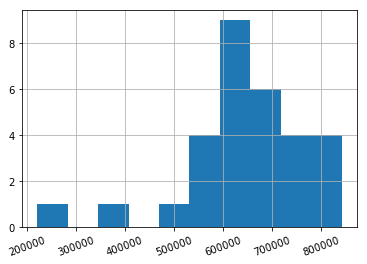

In [25]:
yearly_incidence.hist(xrot=20)